In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Input space transformation (dimensionality reduction)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import random_projection
from sklearn import cluster
from sklearn.random_projection import johnson_lindenstrauss_min_dim

import utils
from model import My_VGG as Model

from DCTDimReducer import DCTDimReducer
from ClusteringAdvClassifier import ClusterAdversarialClassifier as Classifier

# Testing Cluster Adversarial Classifier

## Load Data

In [2]:
# MNIST
X_train, y_train, X_test, y_test = utils.load_mnist()
channels, size, classes = 1, 28, 10
dimensions = (size, size)

# Fashion MNIST
#X_train, y_train, X_test, y_test = utils.load_fashion_mnist()
#channels, size, classes = 1, 28, 10
#dimensions = (size, size)

# CIFAR-10
# X_train, y_train, X_test, y_test = utils.load_cifar10()
# channels, size, classes = 3, 32, 10
# dimensions = (size, size, channels)

## Load Baseline Model (adversarial training)

In [3]:
#baseline_model = utils.load_VGG('trained_models/baseline_model.pt')
baseline_model = utils.load_VGG('trained_models/initial_model.pt')

## Train Clustering Classifier

### Load Base Neural Network For Clustering Detector/Classifier

In [4]:
model = utils.load_VGG('trained_models/initial_model.pt')

### Input Space (Dimensionality Reduction) Transforms - optional

In [5]:
# SKLearn method for determining a "minimum" number of components to reduce the dataset to
#n_comp = johnson_lindenstrauss_min_dim(X_train.shape[0], eps=.99)

# Control (no transform): Wall time: 2min 53s, clean: 0.9733, adv: 0.8829
#transformer = None

# GaussianRandomProjection(n_components=374): Wall time: 1min 47s, clean: 0.9737, adv: 0.8892
# 2nd run: Wall time: 1min 52s, clean: 0.9727, adv: 0.911
#transformer = random_projection.GaussianRandomProjection(n_components=n_comp)

# SparseRandomProjection(n_components=374): Wall time: 1min 46s, clean: 0.9744, adv: 0.9247
# 2nd run: Wall time: 1min 47s, clean: 0.9706, adv: 0.8998
#transformer = random_projection.SparseRandomProjection(n_components=n_comp)

# PCA(n_components=374): Wall time: 1min 53s, clean: 0.9783, adv: 0.9137
# 2nd run: Wall time: 1min 32s, clean: 0.9757, adv: 0.9028
#transformer = PCA(n_components=n_comp)

# FeatureAgglomeration(n_clusters=10):  Wall time: 46.2 s, clean: 0.8512, adv: 0.782
#transformer = cluster.FeatureAgglomeration(n_clusters=10)

# Discrete Cosine Transform
transformer = DCTDimReducer(dimensions, coef_size_reduction=16)

### Fitting the clustering classifier on clean data

In [6]:
# Trying out different parameters for the clustering algorithm:
# Base: C=1, no transform
# Clean data flagged as suspicious by detector: 2.820%
# {'0.02': 97.28999999999999, '0.04': 96.53, '0.08': 93.91000000000001, '0.16': 83.16, '0.24': 64.78, '0.32': 48.89}
# {'0.02': 3.9600000000000004, '0.04': 5.83, '0.08': 14.02, '0.16': 47.75, '0.24': 55.300000000000004, '0.32': 58.68}

# Evaluating on adversarial data
# Baseline Model Accuracies:  {'0.02': 98.7, '0.04': 98.88, '0.08': 99.11, '0.12': 99.18, '0.16': 99.06, '0.24': 96.96000000000001, '0.32': 84.33}

# C = 1, NO transform
# Clustering Model Accuracies:      {'0.02': 97.01, '0.04': 95.34, '0.08': 90.27, '0.12': 86.14, '0.16': 83.78, '0.24': 75.38, '0.32': 63.03}
# Clustering Algorithm Accuracies:  {'0.02': 65.16, '0.04': 82.98, '0.08': 92.84, '0.12': 92.09, '0.16': 87.97, '0.24': 69.27, '0.32': 41.27}
# CNN Accuracies:                   {'0.02': 98.95, '0.04': 97.06, '0.08': 88.76, '0.12': 81.0, '0.16': 80.02, '0.24': 81.1, '0.32': 86.41}
# Clustering Detector Accuracies:   {'0.02': 5.74, '0.04': 12.22, '0.08': 36.99, '0.12': 46.37, '0.16': 47.31, '0.24': 48.36, '0.32': 51.8}

# C = 1, DCT with 5x5 removed elements
# Clustering Model Accuracies:      {'0.02': 96.51, '0.04': 94.7, '0.08': 89.41, '0.12': 84.79, '0.16': 82.25, '0.24': 75.18, '0.32': 66.11}
# Clustering Algorithm Accuracies:  {'0.02': 58.22, '0.04': 78.18, '0.08': 90.49, '0.12': 89.23, '0.16': 84.56, '0.24': 68.0, '0.32': 46.81}
# CNN Accuracies:                   {'0.02': 98.99, '0.04': 97.07, '0.08': 88.78, '0.12': 80.95, '0.16': 80.16, '0.24': 82.09, '0.32': 87.24}
# Clustering Detector Accuracies:   {'0.02': 6.08, '0.04': 12.56, '0.08': 37.0, '0.12': 46.35, '0.16': 47.42, '0.24': 49.07, '0.32': 52.27}

# # C = .1, DCT with 16x16 removed elements
# # Clustering Model Accuracies:      {'0.02': 94.66, '0.04': 93.05, '0.08': 87.81, '0.12': 83.31, '0.16': 80.76, '0.24': 74.56, '0.32': 65.91}
# # Clustering Algorithm Accuracies:  {'0.02': 72.74, '0.04': 84.39, '0.08': 87.26, '0.12': 84.96, '0.16': 80.96, '0.24': 68.28, '0.32': 49.31}
# # CNN Accuracies:                   {'0.02': 99.06, '0.04': 96.99, '0.08': 88.3, '0.12': 81.78, '0.16': 80.58, '0.24': 80.4, '0.32': 82.15}
# # Clustering Detector Accuracies:   {'0.02': 16.73, '0.04': 31.26, '0.08': 47.42, '0.12': 48.2, '0.16': 48.1, '0.24': 48.17, '0.32': 49.46}

# # C = 1, DCT with 16x16 removed elements
# # Clustering Model Accuracies:      {'0.02': 96.55, '0.04': 94.75, '0.08': 89.42, '0.12': 84.77, '0.16': 82.22, '0.24': 75.27, '0.32': 66.78}
# # Clustering Algorithm Accuracies:  {'0.02': 58.85, '0.04': 78.59, '0.08': 90.59, '0.12': 89.24, '0.16': 84.71, '0.24': 68.75, '0.32': 48.75}
# # CNN Accuracies:                   {'0.02': 99.0, '0.04': 97.06, '0.08': 88.74, '0.12': 80.92, '0.16': 79.98, '0.24': 81.44, '0.32': 85.96}
# # Clustering Detector Accuracies:   {'0.02': 6.1, '0.04': 12.52, '0.08': 36.97, '0.12': 46.28, '0.16': 47.3, '0.24': 48.64, '0.32': 51.55}

# # C = 10, DCT with 16x16 removed elements
# # Clustering Model Accuracies:      {'0.02': 97.21, '0.04': 95.25, '0.08': 89.65, '0.12': 84.71, '0.16': 81.2, '0.24': 71.09, '0.32': 62.55}
# # Clustering Algorithm Accuracies:  {'0.02': 51.9, '0.04': 72.09, '0.08': 89.91, '0.12': 89.31, '0.16': 82.92, '0.24': 62.92, '0.32': 45.75}
# # CNN Accuracies:                   {'0.02': 98.82, '0.04': 96.96, '0.08': 89.56, '0.12': 81.15, '0.16': 79.7, '0.24': 78.13, '0.32': 76.57}
# # Clustering Detector Accuracies:   {'0.02': 3.43, '0.04': 6.88, '0.08': 25.86, '0.12': 43.61, '0.16': 46.55, '0.24': 46.28, '0.32': 45.49}

# # C = 100, DCT with 16x16 removed elements
# # Clustering Model Accuracies:      {'0.02': 97.19, '0.04': 95.23, '0.08': 89.15, '0.12': 83.69, '0.16': 80.41, '0.24': 70.39, '0.32': 62.79}
# # Clustering Algorithm Accuracies:  {'0.02': 37.45, '0.04': 63.5, '0.08': 85.9, '0.12': 87.94, '0.16': 81.9, '0.24': 62.41, '0.32': 46.6}
# # CNN Accuracies:                   {'0.02': 98.78, '0.04': 96.99, '0.08': 89.93, '0.12': 81.03, '0.16': 79.19, '0.24': 76.96, '0.32': 75.95}
# # Clustering Detector Accuracies:   {'0.02': 2.59, '0.04': 5.26, '0.08': 19.29, '0.12': 38.48, '0.16': 44.92, '0.24': 45.14, '0.32': 44.83}
    
# C = 1, DCT with 20x20 removed elements
# Clustering Model Accuracies:      {'0.02': 96.53, '0.04': 94.74, '0.08': 89.42, '0.12': 84.68, '0.16': 82.07, '0.24': 75.2, '0.32': 67.22}
# Clustering Algorithm Accuracies:  {'0.02': 58.62, '0.04': 78.5, '0.08': 90.57, '0.12': 89.09, '0.16': 84.28, '0.24': 68.35, '0.32': 49.38}
# CNN Accuracies:                   {'0.02': 98.99, '0.04': 97.06, '0.08': 88.74, '0.12': 80.89, '0.16': 80.08, '0.24': 81.73, '0.32': 86.39}
# Clustering Detector Accuracies:   {'0.02': 6.09, '0.04': 12.51, '0.08': 37.01, '0.12': 46.27, '0.16': 47.38, '0.24': 48.81, '0.32': 51.8}

# C = 1, DCT with 27x27 removed elements
# Clustering Model Accuracies:      {'0.02': 88.15, '0.04': 85.94, '0.08': 80.16, '0.12': 74.01, '0.16': 70.01, '0.24': 61.23, '0.32': 54.89}
# Clustering Algorithm Accuracies:  {'0.02': 18.43, '0.04': 38.04, '0.08': 66.57, '0.12': 66.62, '0.16': 59.81, '0.24': 41.69, '0.32': 28.52}
# CNN Accuracies:                   {'0.02': 99.14, '0.04': 97.32, '0.08': 88.97, '0.12': 80.61, '0.16': 79.57, '0.24': 80.38, '0.32': 81.89}
# Clustering Detector Accuracies:   {'0.02': 13.62, '0.04': 19.19, '0.08': 39.33, '0.12': 47.18, '0.16': 48.37, '0.24': 49.49, '0.32': 50.59}

In [7]:
classifier = Classifier(model, input_transform=transformer, SVC_C = 10)

classifier.fit(X_train, y_train)

## Evaluation

### Scoring classifiers on clean data

In [8]:
print("Baseline classifier on clean test data: %.3f%%" % (utils.eval_model(baseline_model, X_test, y_test) * 100))

print("\nCluster Classifier Accuracy on clean test data: %.3f%%" % (classifier.score(X_test, y_test) * 100))
print("Clean data flagged as suspicious by detector: %.3f%%" % (classifier.proportion_flagged * 100))

Baseline classifier on clean test data: 98.840%

Cluster Classifier Accuracy on clean test data: 97.920%
Clean data flagged as suspicious by detector: 1.930%


## Evaluating on adversarial data

Baseline training epsilon: 0.12

Current epsilon: 0.02


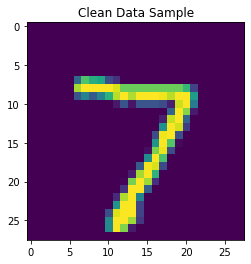

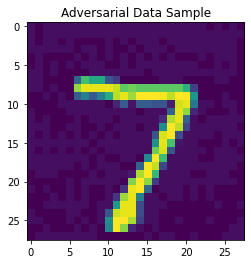

	Adversarial data only:
		Baseline classifier accuracy: 0.978

		Cluster classifier accuracy: 0.972
		Clustering algorithm accuracy: 0.519
		Model accuracy: 0.988
		Input data flagged as suspicious by detector: 0.034

Current epsilon: 0.04


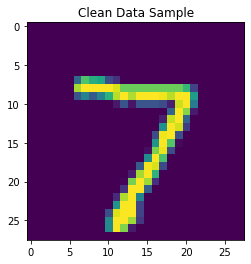

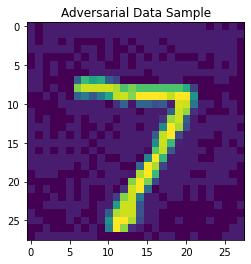

	Adversarial data only:
		Baseline classifier accuracy: 0.943

		Cluster classifier accuracy: 0.953
		Clustering algorithm accuracy: 0.721
		Model accuracy: 0.970
		Input data flagged as suspicious by detector: 0.069

Current epsilon: 0.08


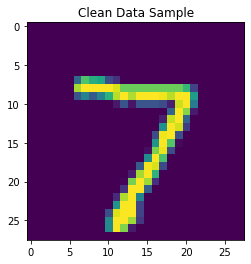

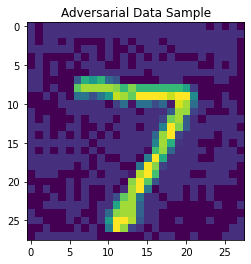

	Adversarial data only:
		Baseline classifier accuracy: 0.794

		Cluster classifier accuracy: 0.896
		Clustering algorithm accuracy: 0.899
		Model accuracy: 0.896
		Input data flagged as suspicious by detector: 0.259

Current epsilon: 0.12


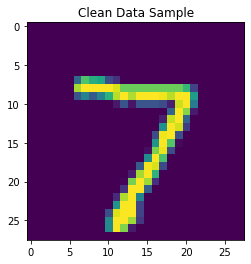

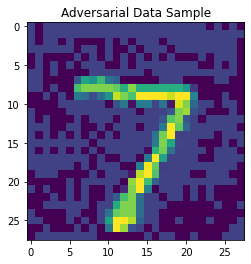

	Adversarial data only:
		Baseline classifier accuracy: 0.584

		Cluster classifier accuracy: 0.847
		Clustering algorithm accuracy: 0.893
		Model accuracy: 0.812
		Input data flagged as suspicious by detector: 0.436

Current epsilon: 0.16


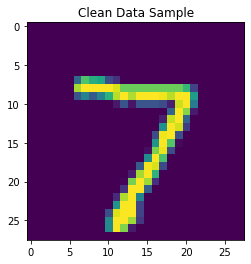

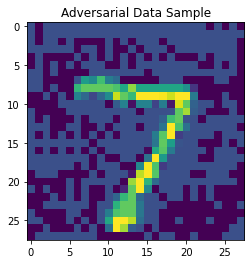

	Adversarial data only:
		Baseline classifier accuracy: 0.472

		Cluster classifier accuracy: 0.812
		Clustering algorithm accuracy: 0.829
		Model accuracy: 0.797
		Input data flagged as suspicious by detector: 0.466

Current epsilon: 0.24


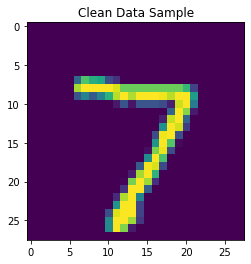

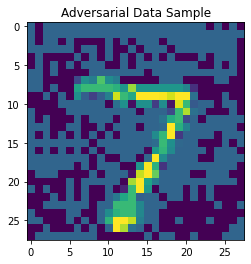

	Adversarial data only:
		Baseline classifier accuracy: 0.431

		Cluster classifier accuracy: 0.711
		Clustering algorithm accuracy: 0.630
		Model accuracy: 0.781
		Input data flagged as suspicious by detector: 0.463

Current epsilon: 0.32


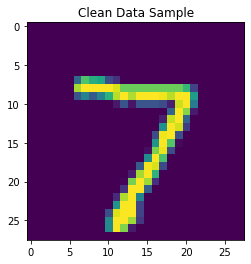

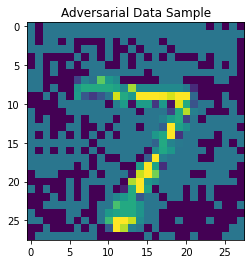

	Adversarial data only:
		Baseline classifier accuracy: 0.424

		Cluster classifier accuracy: 0.626
		Clustering algorithm accuracy: 0.458
		Model accuracy: 0.766
		Input data flagged as suspicious by detector: 0.455


In [9]:
test_eps = [2e-2, 4e-2, 8e-2, 1.2e-1, 1.6e-1, 2.4e-1, 3.2e-1]
print("Baseline training epsilon: %.2f" % (1.2e-1))

baseline_performance = dict()
clustering_classifier_performance = dict()
cluster_accuracy = dict()
cnn_accuracy = dict()
clustering_detector_performance = dict()

test_dataloader = utils.create_dataloader(X_test, y_test)

for eps in test_eps:
    adv_test_data = utils.add_adversarial_noise(model, test_dataloader, eps=eps)
    
    print("\nCurrent epsilon: %.2f" % (eps))
    
    plt.imshow(X_test[0].reshape(dimensions))
    plt.title("Clean Data Sample")
    plt.show()

    plt.imshow(adv_test_data[0].reshape(dimensions))
    plt.title("Adversarial Data Sample")
    plt.show()
    
    # Testing both classifiers on adversarial data only
    # Baseline accuracy
    baseline_performance[str(eps)] = utils.eval_model(baseline_model, adv_test_data, y_test)
    
    print("\tAdversarial data only:")
    print("\t\tBaseline classifier accuracy: %.3f" % (baseline_performance[str(eps)]))

    # Clustering classifier and adversarial detection accuracy
    clustering_classifier_performance[str(eps)] = classifier.score(adv_test_data, y_test)
    cluster_accuracy[str(eps)] = classifier.cluster_accuracy
    cnn_accuracy[str(eps)] = classifier.cnn_accuracy
    clustering_detector_performance[str(eps)] = classifier.proportion_flagged
    
    print("\n\t\tCluster classifier accuracy: %.3f" % (clustering_classifier_performance[str(eps)]))
    print("\t\tClustering algorithm accuracy: %.3f" % (cluster_accuracy[str(eps)]))
    print("\t\tModel accuracy: %.3f" % (cnn_accuracy[str(eps)]))
    print("\t\tInput data flagged as suspicious by detector: %.3f" % (clustering_detector_performance[str(eps)]))

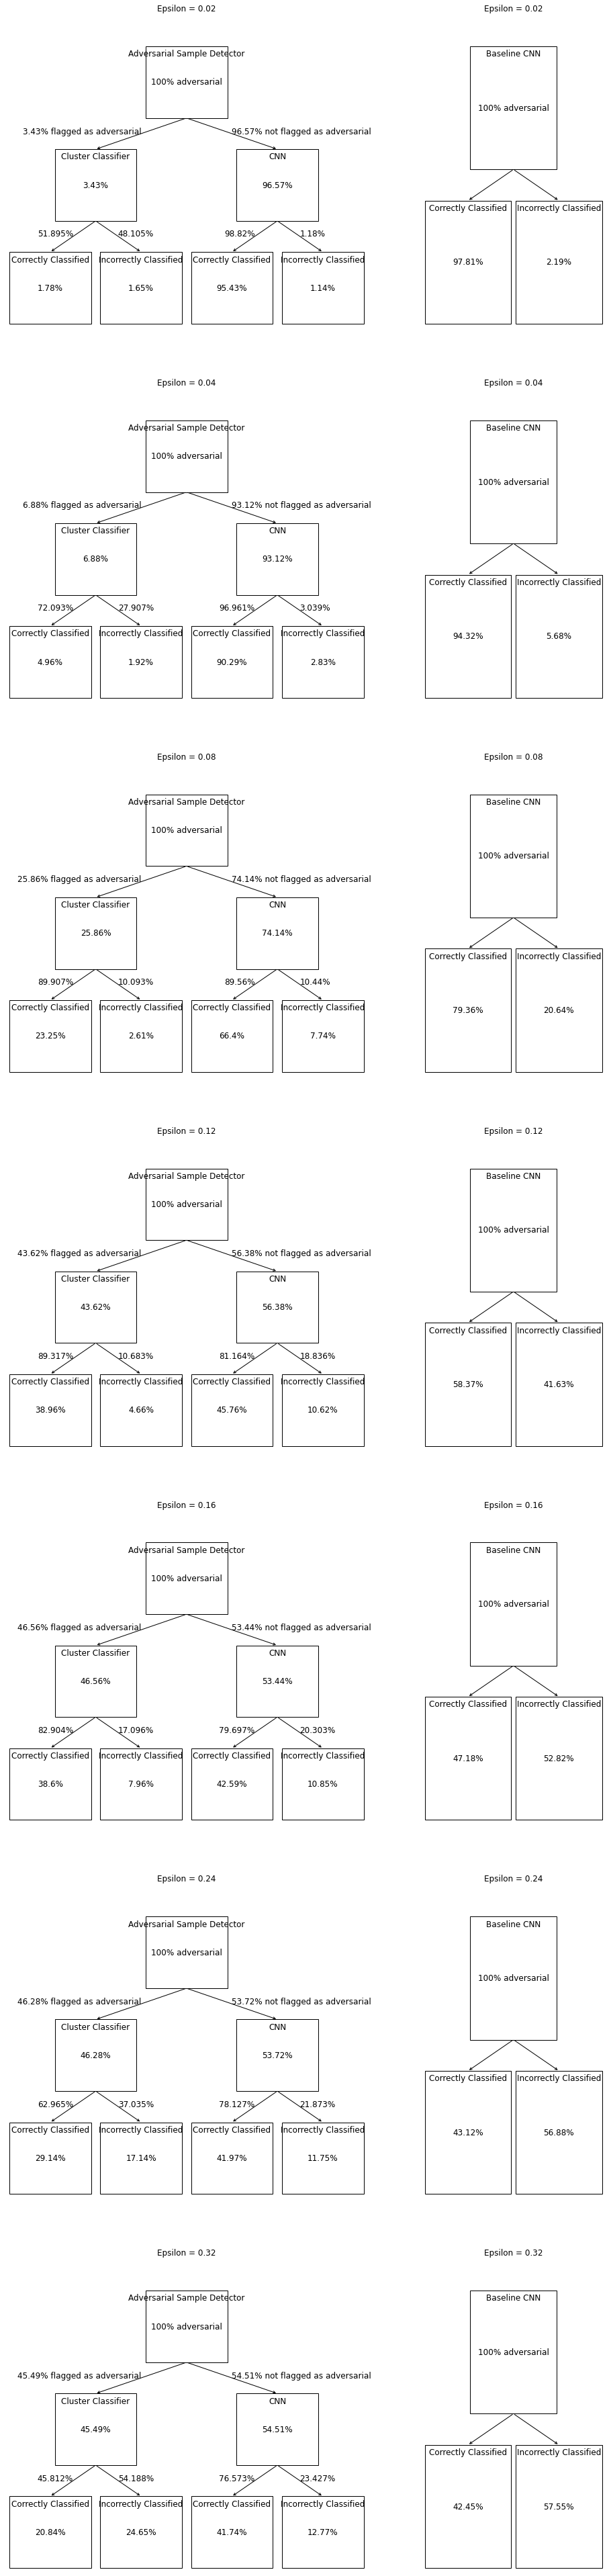

In [14]:
# Clustering classifier results:

# Structure of output:
# Root node: All samples, adversarial sample detector
#     Left child: Percentage of flagged adversarial samples, sent to cluster classifier
#         Left child: percentage of samples correctly classified by cluster classifier
#         Right child: percentage of samples incorrectly classified by cluster classifier
#     Right child: Percentage of non-flagged, "clean" samples, sent to cnn
#         Left child: percentage of samples correctly classified by cnn
#         Right child: percentage of samples incorrectly classified by cnn
node_labels=["Adversarial Sample Detector", "Cluster Classifier", "CNN", "Correctly Classified", 
              "Incorrectly Classified", "Correctly Classified", "Incorrectly Classified"]
absolute_percentages=dict()
relative_percentages=dict()

percentage = lambda x : str(round((x * 100), 3)) + "%"

for eps in test_eps:
    eps = str(eps)
    eps_absolute_percentages=list()
    eps_relative_percentages=list()

    # Relative percentages
    detected_adversarial = clustering_detector_performance[eps]
    not_detected_adversarial = 1 - clustering_detector_performance[eps]

    cluster_classified_correctly = cluster_accuracy[eps]
    cluster_classified_incorrectly = 1 - cluster_accuracy[eps]

    cnn_classified_correctly = cnn_accuracy[eps]
    cnn_classified_incorrectly = 1 - cnn_accuracy[eps]

    # Absolute percentages
    detector_received = 1

    cluster_received = detected_adversarial
    cnn_received = not_detected_adversarial

    cluster_received_correctly_classified = detected_adversarial * cluster_classified_correctly
    cluster_received_incorrectly_classified = detected_adversarial * cluster_classified_incorrectly

    cnn_received_correctly_classified = not_detected_adversarial * cnn_classified_correctly
    cnn_received_incorrectly_classified = not_detected_adversarial * cnn_classified_incorrectly


    # Percentage of samples sent to cluster classifier (correctly classified as adversarial)
    eps_relative_percentages.append(percentage(detected_adversarial) + " flagged as adversarial")
    # Percentage of samples sent to cnn (incorrectly classified as clean)
    eps_relative_percentages.append(percentage(not_detected_adversarial) + " not flagged as adversarial")

    # Percentage of samples received by clustering classifier that were correctly classified
    eps_relative_percentages.append(percentage(cluster_classified_correctly))    
    # Percentage of samples received by clustering classifier incorrectly classified
    eps_relative_percentages.append(percentage(cluster_classified_incorrectly))

    # Percentage of samples received by cnn that were correctly classified
    eps_relative_percentages.append(percentage(cnn_classified_correctly))    
    # Percentage of samples received by cnn that were incorrectly classified
    eps_relative_percentages.append(percentage(cnn_classified_incorrectly))
    
    relative_percentages[eps] = eps_relative_percentages

    eps_absolute_percentages.append(percentage(detector_received) + " adversarial") # 100% of samples are viewed by the root node (detector)

    # Percentage of samples sent to cluster classifier (correctly classified as adversarial)
    eps_absolute_percentages.append(percentage(cluster_received))
    # Percentage of samples sent to cnn (incorrectly classified as clean)
    eps_absolute_percentages.append(percentage(cnn_received))

    # Percentage of all samples correctly classified by clustering classifier
    eps_absolute_percentages.append(percentage(cluster_received_correctly_classified))    
    # Percentage of all samples incorrectly classified by clustering classifier
    eps_absolute_percentages.append(percentage(cluster_received_incorrectly_classified))

    # Percentage of all samples correctly classified by cnn
    eps_absolute_percentages.append(percentage(cnn_received_correctly_classified))    
    # Percentage of all samples incorrectly classified by cnn
    eps_absolute_percentages.append(percentage(cnn_received_incorrectly_classified))
    
    absolute_percentages[eps] = eps_absolute_percentages
    
# Baseline model results:

# Structure of output:
# Root node: All samples, CNN
#     Left child: percentage of samples correctly classified by cnn
#     Right child: percentage of samples incorrectly classified by cnn
bl_node_labels=["Baseline CNN", "Correctly Classified", "Incorrectly Classified"]
bl_percentages=dict()

for eps in test_eps:
    eps = str(eps)
    eps_bl_percentages=["100% adversarial", percentage(baseline_performance[eps]), percentage(1 - baseline_performance[eps])]
    bl_percentages[eps] = eps_bl_percentages

_, axes = plt.subplots(nrows=len(test_eps), ncols=2, figsize=(16,10 * len(test_eps)), gridspec_kw=dict(width_ratios=[2,1]))
for i, eps in enumerate(test_eps):
    eps = str(eps)
    axes[i, 0].set_axis_off()
    axes[i, 0].set_title("Epsilon = " + eps)

    utils.visualize_full_binary_tree(3, node_labels, absolute_percentages[eps], relative_percentages[eps], 
                                     ax=axes[i, 0], text_size='large')
    
    axes[i, 1].set_axis_off()
    axes[i, 1].set_title("Epsilon = " + eps)

    utils.visualize_full_binary_tree(2, bl_node_labels, bl_percentages[eps], ax=axes[i, 1], text_size='large')

plt.show()